In [423]:
# Import numpy and matplotlib
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from time import time
from numba import njit

# Repetition from lecture 6: Brownian Bridge, or tied-down Wiener process

Usually, we create a Wiener process starting from 0, or we can just add any number if we want it to start at a fixed. But what if we want to create a realisation of a Wiener process that passes through _two_ fixed points, at different times? This is called a Brownian Bridge, or a tied-down Wiener process (see Eq. (1.8.7) at page 44 in Kloeden & Platen).

The construction has three steps:
* Decide the points the process should pass through, $(x_0, t_0)$ and $(x_1, t_1)$, where $t_1 > t_0$.
* Create a (random) realisation of a Wiener process starting at $(0, t_0)$, ending at $(W_{t_1}, t_1)$.
* Add an offset that increases linearly from $x_0$ at time $t_0$ to $x_1-W_{t_1}$ at time $t_1$.

This is illustrated below.

In [2]:
def bridge(t0, t1, x0, x1, Np, Nsteps):
    # adapted from Kloeden & Platen 1992, Eq. (1.8.7), p. 44
    dt = (t1 - t0) / Nsteps
    t  = np.linspace(t0, t1, Nsteps + 1)
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Np, Nsteps))
    W  = np.zeros((Np, Nsteps + 1))
    W[:,1:] = np.cumsum(dW, axis = 1)
    B  = x0 + W - ((t - t0)/(t1 - t0)) * (W[:,-1] - x1 + x0)[:,None]
    return t, B

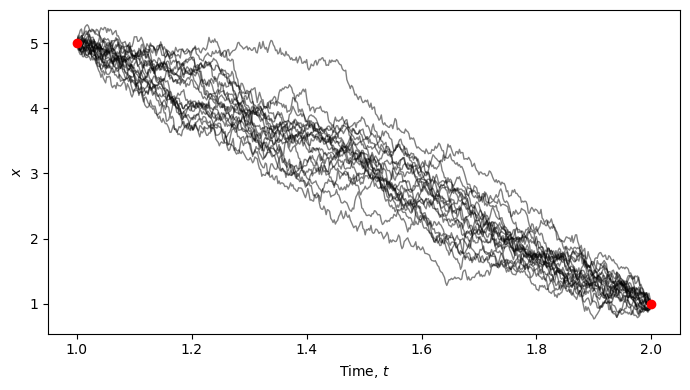

In [3]:
x0, t0 = 5, 1
x1, t1 = 1, 2

Nt = 500
Np = 20
t, B = bridge(t0, t1, x0, x1, Np, Nt)

fig = plt.figure(figsize=(7,4))
plt.scatter([t0, t1], [x0, x1], c='r', zorder=1)
plt.plot(t, B[:,:].T, c='k', lw=1, alpha=0.5, zorder=0)
plt.xlabel('Time, $t$')
plt.ylabel('$x$')
plt.tight_layout()

# Distribution of intermediate points on Brownian bridge

Assume that we have the values of the Wiener process given at two times, $W_{t}$ and $W_{t+\Delta t}$, and that we want to find the value at an intermediate point $t+q\Delta t$ where $q\in[0,1]$.

The distribution of values at any intermediate point $t \leq t + q\Delta t \leq t + \Delta t$ is

$$ W_{t+q\Delta t} \sim \mathcal{N}\big(W_{t} + q (W_{t+\Delta t} - W_t), q(1-q)\Delta t \big). $$

In other words, the value at the intermediate point is a Gaussian random number, with expectation value $\mu$ found by linear interpolation between $W_{t}$ and $W_{t+\Delta t}$, and variance given by $\sigma^2 = q(1-q)\Delta t$.

# Relevance to adaptive SDE methods

An important part of the error control routine in an adaptive method, both for ODEs and SDEs, is the rejection of steps when the error is estimated to be larger than allowed by the tolerance. In an ODE method, this is no problem, as we just try again with a reduced timestep.

For SDEs, we need to use numerical realisations of the Wiener process with the correct statistical properties. If we just reject steps and draw new random numbers, we will bias the Wiener process:
* Large values of $\Delta W$ will typically lead to larger steps, and thus be more likely to be rejected. This will reduce the variance of the Wiener process.
* Steps in a certain direction may be more likely to be rejected (for example stepping towards a region where the coefficients $a(X, t)$ and $b(X, t)$ have larger values). This may skew the Wiener process and make it asymmetric.


### Solution: Use the properties of the Brownian bridge to interpolate the Wiener process

Say we draw a random value $\Delta W \sim \mathcal{N}(0, \Delta t)$, attempt to make a step with the integrator, and then find that we have to reject the step, and try again with a shorter timestep $q\Delta t$ with $q\in [0, 1]$. Instead of throwing away our value of $\Delta W$, we instead use the Brownian bridge to interpolate $W_t$ to the intermediate point, by drawing a new random value:

$$ \Delta \tilde{W} \sim \mathcal{N}\big( q \Delta W, q(1-q)\Delta t \big),$$

and re-try the step with the reduced timestep $q \Delta t$. If that step is accepted, we then attempt another step, with length $(1-q)\Delta t$, and with the random value $\Delta \bar{W} = \Delta W - \Delta \tilde{W}$. With this approach, we do not throw away any of the random numbers we generate, and we avoid introducing any biases into the Wiener process.

# Adaptive SDE method from Rackauckas & Nie (2017)

The method below is an implementation of the method called ESRK1 from Rackauckas & Nie (2017):

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5844583/pdf/nihms920388.pdf

The method is described by Eqs. (2) - (4) and Table 1. It is a strong order 1.5 method of the type called Stochastic Runge-Kutta (SRK) methods, with an error estimate that comes from the difference between the order 1.5 method and an embebbed order 1.0 method. The term "embedded" here means that the error estimate can be obtained with no additional evaluations of the functions $a(X, t)$ and $b(X, t)$, it is enough to use the evaluations that are already computed for the order 1.5 method.

In fact this method does not explicitly compute two different estimates of the next step, but rather constructs the error estimate directly (see Eq. (9) in Rackauckas & Nie).

The implementation below is a more or less direct translation from the Julia library StochasticDiffEq.jl.

In [443]:
# Coefficients of the method, found here:
# https://github.com/SciML/StochasticDiffEq.jl/blob/9d8eb5503f1d78cdb0de76691af2a89c20085486/src/tableaus.jl#L40
# Note that the method is called SRIW1 in the Julia library,
# and ESRK1 in the paper by Rackauckas & Nie.

c0 = np.array([0, 3/4, 0, 0])
c1 = np.array([0, 1/4, 1, 1/4])
A0 = np.array([
    [0,   0, 0, 0],
    [3/4, 0, 0, 0],
    [0,   0, 0, 0],
    [0,   0, 0, 0],
])
A1 = np.array([
    [0,   0,   0, 0],
    [1/4, 0,   0, 0],
    [1,   0,   0, 0],
    [0,   0, 1/4, 0],
])
B0 = np.array([
    [0,   0, 0, 0],
    [3/2, 0, 0, 0],
    [0,   0, 0, 0],
    [0,   0, 0, 0],
])
B1 = np.array([
    [0,   0,   0, 0],
    [1/2, 0,   0, 0],
    [-1,  0,   0, 0],
    [-5,  3, 1/2, 0],
])
alpha = np.array([ 1/3,  2/3,    0, 0])
beta1 = np.array([-1,    4/3,  2/3, 0])
beta2 = np.array([-1,    4/3, -1/3, 0])
beta3 = np.array([ 2,   -4/3, -2/3, 0])
beta4 = np.array([-2,    5/3, -2/3, 1])


# Implementation of the method, translated from Julia code found here:
# https://github.com/SciML/StochasticDiffEq.jl/blob/9d8eb5503f1d78cdb0de76691af2a89c20085486/src/perform_step/sri.jl#L58
# Note that the method is general and can also be used with other coefficients
def ESRK1(U, t, dt, f, g, dW, dZ):
    sqrt3 = np.sqrt(3)
    chi1 = (dW**2 - np.abs(dt)) / (2*np.sqrt(dt))
    chi2 = (dW + dZ/sqrt3)/2
    chi3 = (dW**3 - 3*dW*dt) / (6*dt)

    stages = 4
    H0 = np.zeros(stages)
    H1 = np.zeros(stages)
    
    for i in range(stages):
        A0temp = 0.0
        B0temp = 0.0
        A1temp = 0.0
        B1temp = 0.0
        
        for j in range(i):
            ftemp = f(H0[j], t+c0[j]*dt)
            gtemp = g(H1[j], t+c1[j]*dt)
            A0temp = A0temp + A0[i,j]*ftemp
            B0temp = B0temp + B0[i,j]*gtemp
            A1temp = A1temp + A1[i,j]*ftemp
            B1temp = B1temp + B1[i,j]*gtemp

        H0[i] = U + A0temp*dt + B0temp*chi2
        H1[i] = U + A1temp*dt + B1temp*np.sqrt(dt)
        
    atemp = 0.0
    btemp = 0.0
    E2 = 0.0
    E1temp = 0.0
            
    for i in range(stages):
        ftemp = f(H0[i], t+c0[i]*dt)
        gtemp = g(H1[i], t+c1[i]*dt)
        atemp = atemp + alpha[i]*ftemp
        btemp = btemp + (beta1[i]*dW   + beta2[i]*chi1)*gtemp
        E2    = E2    + (beta3[i]*chi2 + beta4[i]*chi3)*gtemp
            
    E1 = dt * E1temp
    
    # Next position
    U_ =  U + (dt*atemp + btemp) + E2 
    # Error estimate
    E = E1 + E2
    return U_, E

# Adaptive SDE solver from Rackauckas & Nie (2017)

The implementation below is based on Algorithm 1 at page 2741 in Rackauckas & Nie. Note that below we use the symbol $h$ for the timestep, to be consistent with the relevant section of the paper (elsewhere in the same paper the also use $\Delta t$).

In [444]:
def RSwM1(X0, Tmax, h0, a, b, eps_abs=1e-5, eps_rel=1e-5, hmax=1):
    # Initial values
    t = 0.
    h = h0
    W = 0.
    Z = 0.
    X = X0
    # Lists to keep entire solution (for plotting, etc)
    X_list = []
    t_list = []
    W_list = []
    # Stack for keeping track of unused random numbers
    S = []
    # Draw first random numbers
    # Note, in this method dW and dZ are uncorrelated
    dW, dZ = np.random.normal(loc=0, scale=np.sqrt(h), size=2)
    # Loop over time
    while t < Tmax:
        # Take an attempted step and estimate error
        X_, E = ESRK1(X, t, h, a, b, dW, dZ)
        # Calculate timestep adjustment factor, Eqs. (19) - (21)
        gamma = 2
        sc = eps_abs + np.abs(X)*eps_rel
        e  = np.abs(E/sc) + 1e-12 # Adding a small constant to avoid random divides by zero
        q  = (1/(gamma*e))**(1/2)
        
        if q < 1:
            # Step is rejected
            dW_tilde = np.random.normal(loc=q*dW, scale=np.sqrt((1-q)*q*h))
            dZ_tilde = np.random.normal(loc=q*dZ, scale=np.sqrt((1-q)*q*h))
            dW_bar = dW - dW_tilde
            dZ_bar = dZ - dZ_tilde
            S.append( ((1-q)*h, dW_bar, dZ_bar) )
            h = q*h
            dW = dW_tilde
            dZ = dZ_tilde
        else:
            # Step is accepted
            # Update position, time, W and Z
            X = X_
            t = t + h
            W = W + dW
            Z = Z + dZ
            # Update lists
            X_list.append(X)
            t_list.append(t)
            W_list.append(W)

            # Check if there are unused random numbers on the stack
            if len(S) == 0:
                # Stack is empty, adjust timestep and draw new random numbers
                c = min(3*h, q*h)
                h = min(c, Tmax - t)
                # Round-off error can lead to t > Tmax at the last step,
                # which gives h < 0 and an error in the sqrt below.
                if h < 0:
                    break
                dW, dZ = np.random.normal(loc=0, scale=np.sqrt(h), size=2)
            else:
                # Stack is not empty, step to time of the next random number on the stack
                h, dW, dZ = S.pop()
            
    # Time integration finished, return lists of values
    return np.array(X_list), np.array(t_list), np.array(W_list)

In [445]:
# Parameters of SDE to solve
a_ = 1.0
b_ = 1
X0 = 1.2

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Numerical parameters
Tmax = 1
dt0 = 0.1

tol = 1e-3
X, t, W = RSwM1(X0, Tmax, dt0, a, b, eps_rel=tol, eps_abs=tol)

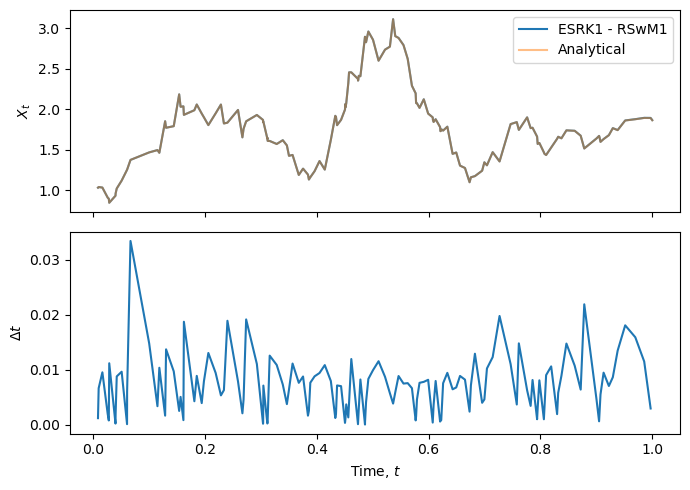

In [446]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(7,5))
ax[0].plot(t, X, label='ESRK1 - RSwM1')
ax[0].plot(t, X0 * np.exp((a_-b_**2/2)*t + b_*W), alpha=0.5, label='Analytical')
ax[1].plot(t[:-1], t[1:] - t[:-1])

ax[0].legend()
ax[0].set_ylabel('$X_t$')
ax[1].set_ylabel('$\Delta t$')
ax[1].set_xlabel('Time, $t$')
plt.tight_layout()

In [447]:
# Parameters of SDE to solve
a_ = 1.0
b_ = 1
X0 = 1.2

# Implementing a and b as functions of X and t,
# for consistency with the general solver
def a(X, t):
    return a_ * X

def b(X, t):
    return b_ * X

# Numerical parameters
Tmax = 1
dt0 = 0.1 # Initial timestep

Nruns = 20
tolerances = np.logspace(-6, -1, 12)
errors = np.zeros(len(tolerances))

tic = time()
for i, tol in enumerate(tolerances):
    for n in range(Nruns):
        X, t, W = RSwM1(X0, Tmax, dt0, a, b, eps_rel=tol, eps_abs=tol)
        errors[i] += np.abs(X[-1] - X0 * np.exp((a_-b_**2/2)*t[-1] + b_*W[-1])) / Nruns
toc = time()

print(f'Took {toc-tic:.3f} seconds to run')

Took 31.264 seconds to run


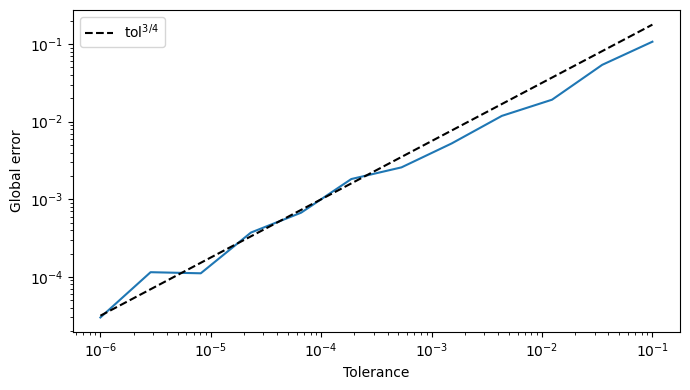

In [448]:
fig = plt.figure(figsize=(7,4))

plt.plot(tolerances, errors)
plt.plot(tolerances, tolerances**(3/4), '--', c='k', label='tol$^{3/4}$')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Global error')
plt.xlabel('Tolerance')
plt.tight_layout()

# Attempting to speed up computations with numba

Below is the same methods as above, but re-written a little to be compatible with numba.

In [431]:
@njit
def ESRK1(U, t, dt, f, g, dW, dZ):
    
    c0 = np.array([0., 3/4, 0, 0])
    c1 = np.array([0., 1/4, 1, 1/4])
    A0 = np.array([
        [0.,   0, 0, 0],
        [3/4, 0, 0, 0],
        [0.,   0, 0, 0],
        [0.,   0, 0, 0],
    ])
    A1 = np.array([
        [0.,   0,   0, 0],
        [1/4, 0,   0, 0],
        [1.,   0,   0, 0],
        [0.,   0, 1/4, 0],
    ])
    B0 = np.array([
        [0.,   0, 0, 0],
        [3/2, 0, 0, 0],
        [0.,   0, 0, 0],
        [0.,   0, 0, 0],
    ])
    B1 = np.array([
        [0.,   0,   0, 0],
        [1/2, 0,   0, 0],
        [-1.,  0,   0, 0],
        [-5.,  3, 1/2, 0],
    ])
    alpha = np.array([ 1/3,  2/3,    0, 0])
    beta1 = np.array([-1.,    4/3,  2/3, 0])
    beta2 = np.array([-1.,    4/3, -1/3, 0])
    beta3 = np.array([ 2.,   -4/3, -2/3, 0])
    beta4 = np.array([-2.,    5/3, -2/3, 1])

    sqrt3 = np.sqrt(3)
    chi1 = (dW**2 - np.abs(dt)) / (2*np.sqrt(dt))
    chi2 = (dW + dZ/sqrt3)/2
    chi3 = (dW**3 - 3*dW*dt) / (6*dt)

    stages = 4
    H0 = np.zeros(stages)
    H1 = np.zeros(stages)
    
    for i in range(stages):
        A0temp = 0.0
        B0temp = 0.0
        A1temp = 0.0
        B1temp = 0.0
        
        for j in range(i):
            ftemp = f(H0[j], t+c0[j]*dt)
            gtemp = g(H1[j], t+c1[j]*dt)
            A0temp = A0temp + A0[i,j]*ftemp
            B0temp = B0temp + B0[i,j]*gtemp
            A1temp = A1temp + A1[i,j]*ftemp
            B1temp = B1temp + B1[i,j]*gtemp

        H0[i] = U + A0temp*dt + B0temp*chi2
        H1[i] = U + A1temp*dt + B1temp*np.sqrt(dt)
        
    atemp = 0.0
    btemp = 0.0
    E2 = 0.0
    E1temp = 0.0
            
    for i in range(stages):
        ftemp = f(H0[i], t+c0[i]*dt)
        gtemp = g(H1[i], t+c1[i]*dt)
        atemp = atemp + alpha[i]*ftemp
        btemp = btemp + (beta1[i]*dW   + beta2[i]*chi1)*gtemp
        E2    = E2    + (beta3[i]*chi2 + beta4[i]*chi3)*gtemp
            
    E1 = dt * E1temp
    
    # Next position
    U_ =  U + (dt*atemp + btemp) + E2 
    # Error estimate
    E = E1 + E2
    return np.array([U_, E])

@njit
def RSwM1(X0, Tmax, h0, a, b, eps_abs=1e-5, eps_rel=1e-5, hmax=1):
    # Initial values
    t = 0.
    h = h0
    W = 0.
    Z = 0.
    X = X0
    # Lists to keep entire solution (for plotting, etc)
    X_list = []
    t_list = []
    W_list = []
    # Stack for keeping track of unused random numbers
    S = []
    # Draw first random numbers
    # Note, in this method dW and dZ are uncorrelated
    dW, dZ = np.random.normal(loc=0, scale=np.sqrt(h), size=2)
    # Loop over time
    while t < Tmax:
        # Take an attempted step and estimate error
        X_, E = ESRK1(X, t, h, a, b, dW, dZ)
        # Calculate timestep adjustment factor, Eqs. (19) - (21)
        gamma = 2
        sc = eps_abs + np.abs(X)*eps_rel
        e  = np.abs(E/sc) + 1e-12 # Adding a small constant to avoid random divides by zero
        q  = (1/(gamma*e))**(1/2)
        
        if q < 1:
            # Step is rejected
            dW_tilde = np.random.normal(loc=q*dW, scale=np.sqrt((1-q)*q*h))
            dZ_tilde = np.random.normal(loc=q*dZ, scale=np.sqrt((1-q)*q*h))
            dW_bar = dW - dW_tilde
            dZ_bar = dZ - dZ_tilde
            S.append( ((1-q)*h, dW_bar, dZ_bar) )
            h = q*h
            dW = dW_tilde
            dZ = dZ_tilde
        else:
            # Step is accepted
            # Update position, time, W and Z
            X = X_
            t = t + h
            W = W + dW
            Z = Z + dZ
            # Update lists
            X_list.append(X)
            t_list.append(t)
            W_list.append(W)

            # Check if there are unused random numbers on the stack
            if len(S) == 0:
                # Stack is empty, adjust timestep and draw new random numbers
                c = min(3*h, q*h)
                h = min(c, Tmax - t)
                # Round-off error can lead to t > Tmax at the last step,
                # which gives h < 0 and an error in the sqrt below.
                if h < 0:
                    break
                dW, dZ = np.random.normal(loc=0, scale=np.sqrt(h), size=2)
            else:
                # Stack is not empty, step to time of the next random number on the stack
                h, dW, dZ = S.pop()
            
    # Time integration finished, return lists of values
    return np.array(X_list), np.array(t_list), np.array(W_list)

In [432]:
# Implementing a and b as functions of X and t,
# for consistency with the general solver
@njit
def a(X, t):
    a_ = 1.0
    return a_ * X

@njit
def b(X, t):
    b_ = 1.0
    return b_ * X


In [440]:
# Parameters of SDE to solve
X0 = 1.2

# Numerical parameters
Tmax = 1
dt0 = 0.1 # Initial timestep

Nruns = 20
tolerances = np.logspace(-6, -1, 12)
errors = np.zeros(len(tolerances))

tic = time()
for i, tol in enumerate(tolerances):
    for n in range(Nruns):
        X, t, W = RSwM1(X0, Tmax, dt0, a, b, eps_rel=tol, eps_abs=tol)
        errors[i] += np.abs(X[-1] - X0 * np.exp((a_-b_**2/2)*t[-1] + b_*W[-1])) / Nruns
toc = time()

print(f'Took {toc-tic:.3f} seconds to run')

Took 3.148 seconds to run


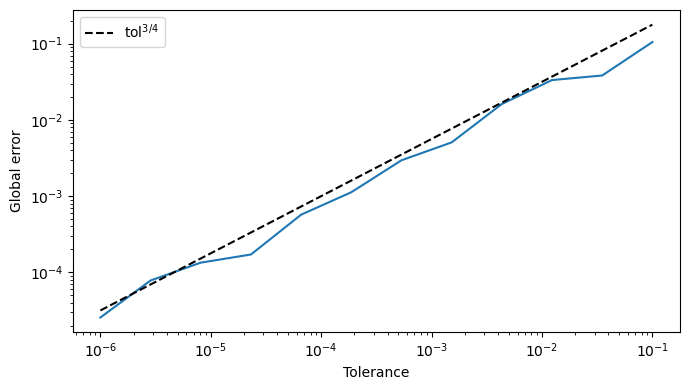

In [441]:
fig = plt.figure(figsize=(7,4))

plt.plot(tolerances, errors)
plt.plot(tolerances, tolerances**(3/4), '--', c='k', label='tol$^{3/4}$')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Global error')
plt.xlabel('Tolerance')
plt.tight_layout()